In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import corner
from astropy.cosmology import Planck18
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyro import distributions as dist
import zuko
import os
import pandas as pd
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
from bed.grid import Grid, TopHat, CosineBump, Gaussian
#device = "cpu"
print(f'Using device: {device}.')

desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')

Using device: cuda:0.


In [23]:
Om_range = torch.tensor([0.1, 0.5], device=device)

params = Grid(Om=np.linspace(*Om_range.cpu().numpy(), 100), 
            w0=np.linspace(-3, 1, 100), 
            wa=np.linspace(-3, 2, 100))

In [24]:
Om_range = torch.tensor([0.0, 1.0], device="cuda:0")
print(f'Om range: {Om_range}')
w0_range = torch.tensor([-3.0, 1.0], device="cuda:0")
wa_range = torch.tensor([-3.0, 2.0], device="cuda:0")

Om range: tensor([0., 1.], device='cuda:0')


In [25]:
params = {"Om": Om_range, "w0": w0_range, "wa": wa_range}
priors = {'Om': dist.Uniform(*Om_range), 'w0': dist.Uniform(*w0_range), 'wa': dist.Uniform(*wa_range)}

In [29]:
torch.linspace(*params[p], 100, device=device)

tensor([-3.0000, -2.9495, -2.8990, -2.8485, -2.7980, -2.7475, -2.6970, -2.6465,
        -2.5960, -2.5455, -2.4949, -2.4444, -2.3939, -2.3434, -2.2929, -2.2424,
        -2.1919, -2.1414, -2.0909, -2.0404, -1.9899, -1.9394, -1.8889, -1.8384,
        -1.7879, -1.7374, -1.6869, -1.6364, -1.5859, -1.5354, -1.4848, -1.4343,
        -1.3838, -1.3333, -1.2828, -1.2323, -1.1818, -1.1313, -1.0808, -1.0303,
        -0.9798, -0.9293, -0.8788, -0.8283, -0.7778, -0.7273, -0.6768, -0.6263,
        -0.5758, -0.5253, -0.4747, -0.4242, -0.3737, -0.3232, -0.2727, -0.2222,
        -0.1717, -0.1212, -0.0707, -0.0202,  0.0303,  0.0808,  0.1313,  0.1818,
         0.2323,  0.2828,  0.3333,  0.3838,  0.4343,  0.4848,  0.5354,  0.5859,
         0.6364,  0.6869,  0.7374,  0.7879,  0.8384,  0.8889,  0.9394,  0.9899,
         1.0404,  1.0909,  1.1414,  1.1919,  1.2424,  1.2929,  1.3434,  1.3939,
         1.4444,  1.4949,  1.5455,  1.5960,  1.6465,  1.6970,  1.7475,  1.7980,
         1.8485,  1.8990,  1.9495,  2.00

In [109]:
def compare_plot(exp_name, var):

    client = MlflowClient()
    exp_id = client.get_experiment_by_name(exp_name).experiment_id
    run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    full_loss = []
    for i, run_id in enumerate(run_ids):
        loss_history = client.get_metric_history(run_id, 'loss')
        losses = [metric.value for metric in loss_history]
        full_loss.append(losses)
        steps = len(losses)
        artifact_uri = client.get_run(run_id).info.artifact_uri
        sigma = client.get_run(run_id).data.params[var]
        eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
        ax2.plot(eigs, alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=colors[i])
        if os.path.exists(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy"):
            brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
            ax2.plot(brute_force_eigs, color=colors[i])
    loss = np.array(full_loss)
    for i, run_id in enumerate(run_ids):
        loss_history = client.get_metric_history(run_id, 'loss')
        losses = [metric.value for metric in loss_history]
        full_loss.append(losses)
        steps = len(losses)
        artifact_uri = client.get_run(run_id).info.artifact_uri
        sigma = client.get_run(run_id).data.params[var]
        ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors[i], label=f"{var}={sigma}")

    ax1.set_xlabel("Training Step")
    ax1.set_ylabel("Loss")
    ax1.set_yscale('log')
    ax2.set_xlabel("Design Index")
    ax2.set_ylabel("Expected Information Gain [bits]")
    ax1.legend()
    plt.show()

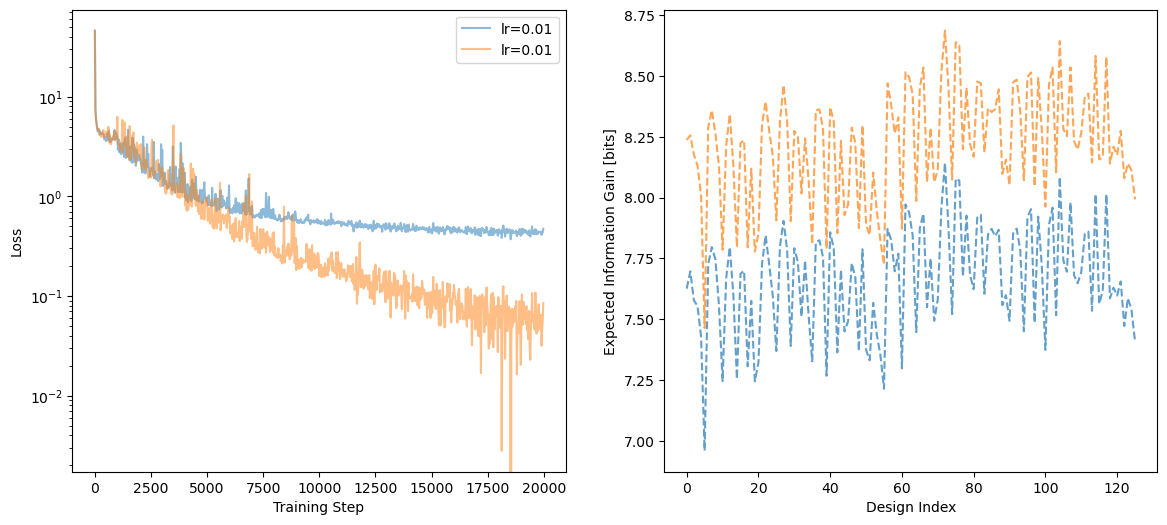

In [110]:
compare_plot("5_tracers_3D", "lr")

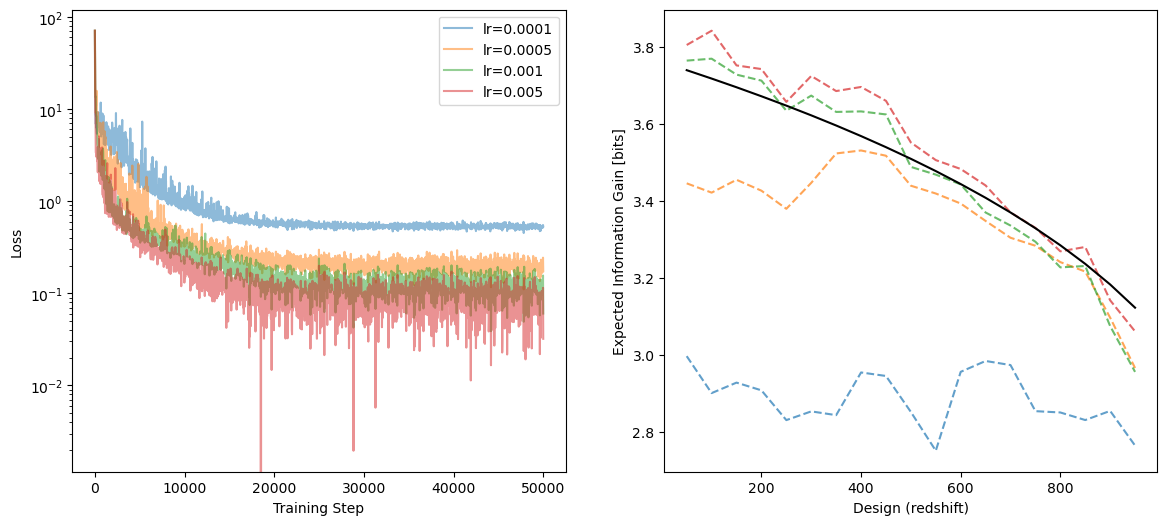

In [4]:

client = MlflowClient()
exp_name = "n_tracers_2D_lr"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'lr'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color='black')
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

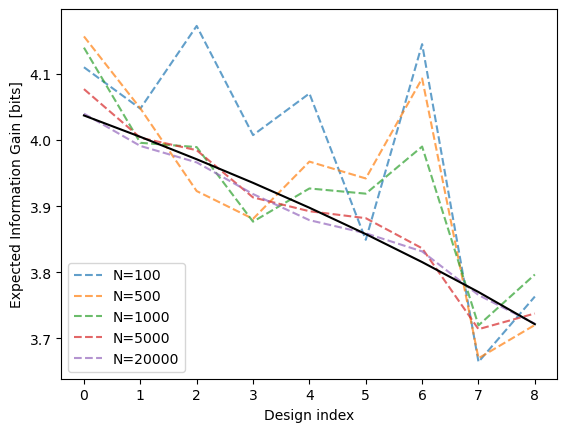

In [54]:
client = MlflowClient()
exp_name = "2_tracers_eval"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

plt.figure()
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['eval_particles']))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for r in run_ids:
    eigs = np.load(f"mlruns/{exp_id}/{r}/artifacts/eigs.npy")
    plt.plot(eigs, alpha=0.7, label=f"N={client.get_run(r).data.params['eval_particles']}", linestyle='--', color=colors.pop(0))

brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_ids[0]}/artifacts/brute_force_eigs.npy")
plt.plot(brute_force_eigs, color='black')
plt.xlabel("Design index")
plt.ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

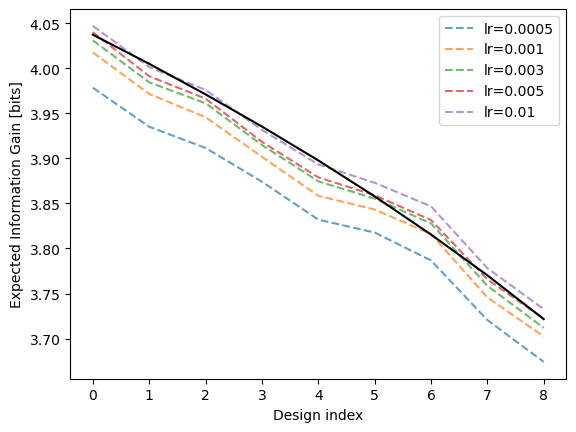

In [3]:
client = MlflowClient()
exp_name = "2_tracers_lr"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

plt.figure()
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for r in run_ids:
    eigs = np.load(f"mlruns/{exp_id}/{r}/artifacts/eigs.npy")
    plt.plot(eigs, alpha=0.7, label=f"lr={client.get_run(r).data.params['lr']}", linestyle='--', color=colors.pop(0))

brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_ids[0]}/artifacts/brute_force_eigs.npy")
plt.plot(brute_force_eigs, color='black')
plt.xlabel("Design index")
plt.ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

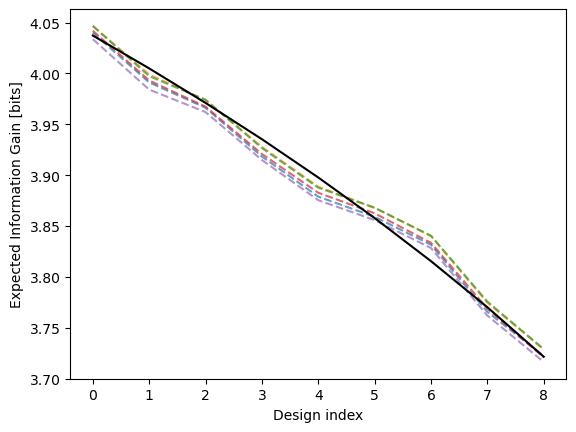

In [6]:
client = MlflowClient()
exp_name = "2_tracers_seed"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]
var = 'seed'
plt.figure()
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for r in run_ids:
    eigs = np.load(f"mlruns/{exp_id}/{r}/artifacts/eigs.npy")
    plt.plot(eigs, alpha=0.7, label=f"lr={client.get_run(r).data.params[var]}", linestyle='--', color=colors.pop(0))

brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_ids[0]}/artifacts/brute_force_eigs.npy")
plt.plot(brute_force_eigs, color='black')
plt.xlabel("Design index")
plt.ylabel("Expected Information Gain [bits]")
#plt.legend()
plt.show()

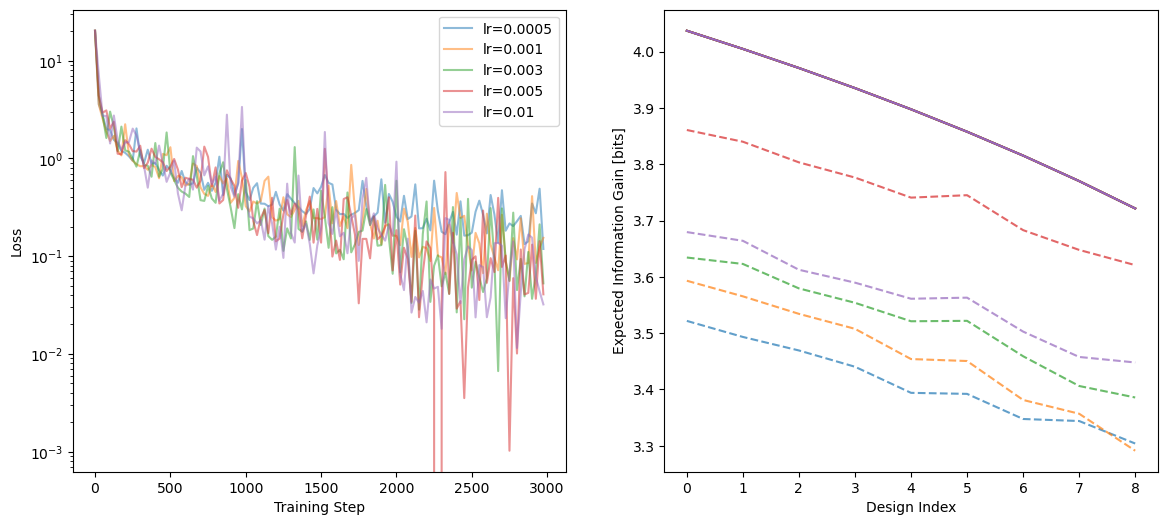

In [79]:
compare_plot("2_tracers_lr", "lr")

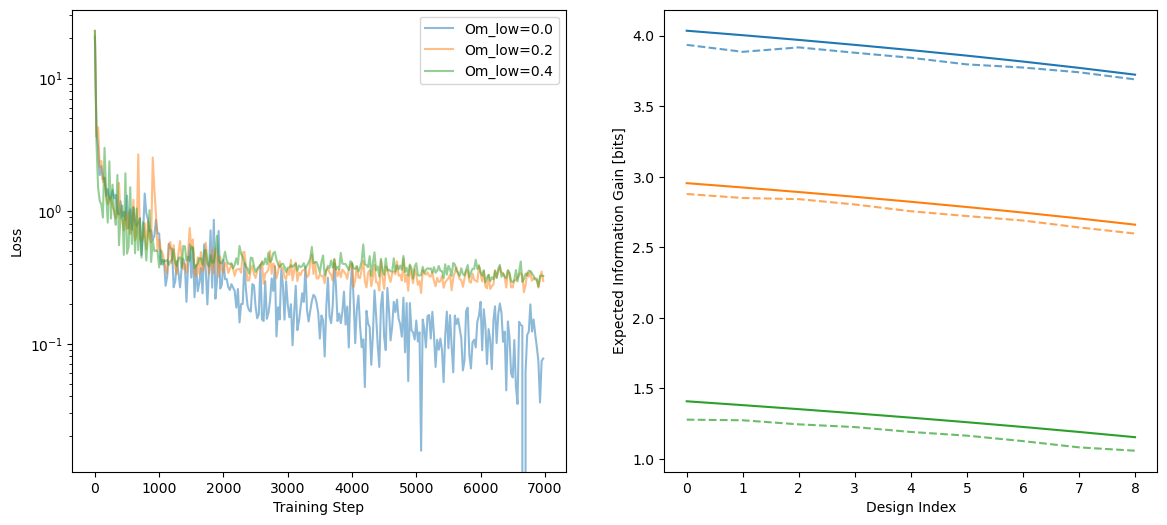

In [12]:
compare_plot("2_tracers_low_10000", "Om_low")

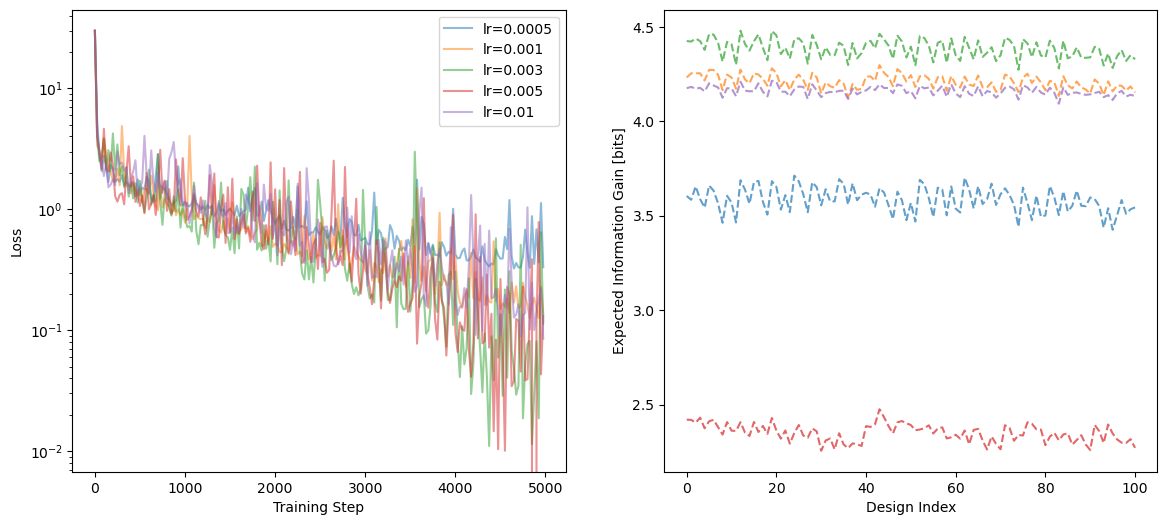

In [10]:
compare_plot("5_tracers_lr", "lr")

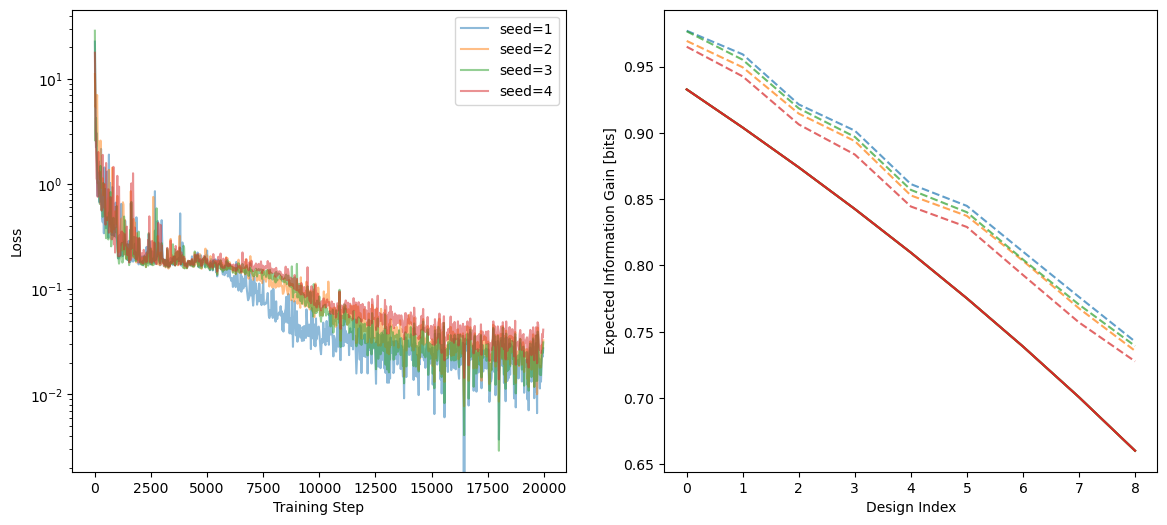

In [3]:
compare_plot("2_tracers_seed", "seed")

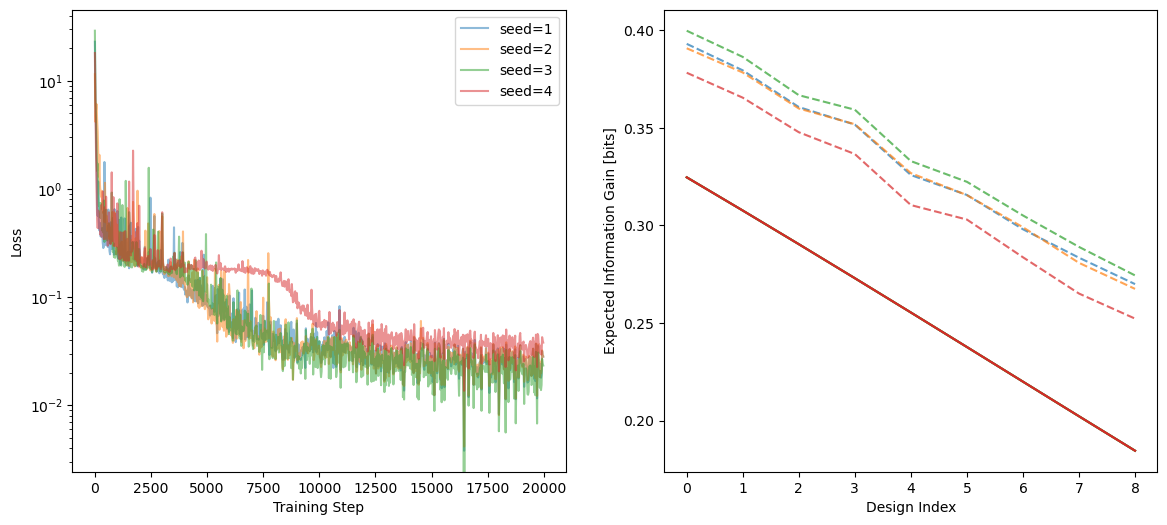

In [3]:
compare_plot("2_tracers_seed_2", "seed")

In [6]:
exp_id

'402292313377668743'

In [14]:
client = MlflowClient()
exp_name = "2_tracers_sigma"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
var_name = 'Om_sigma'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var_name]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
full_loss = []
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    var = np.round(float(client.get_run(run_id).data.params[var_name]),3)
    print(var)

0.01
0.015
0.02
0.025
0.03
0.04
0.05


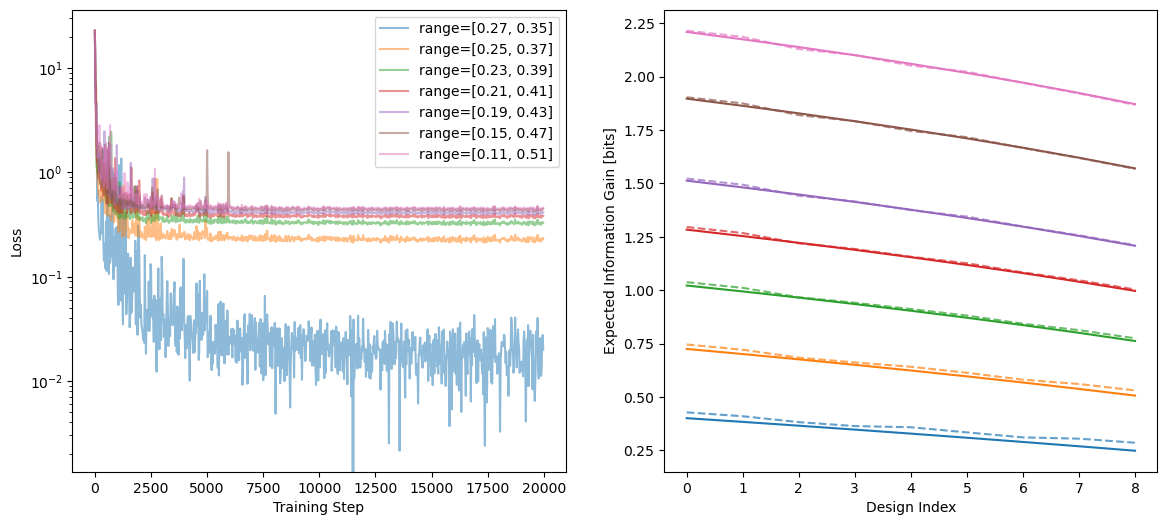

In [3]:
client = MlflowClient()
exp_name = "2_tracers_sigma"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
var_name = 'Om_sigma'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var_name]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
full_loss = []
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    var = np.round(float(client.get_run(run_id).data.params[var_name]),3)
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs, alpha=0.7, label=f"{var_name}={var}", linestyle='--', color=colors[i])
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs, color=colors[i])
loss = np.array(full_loss)
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    var = float(client.get_run(run_id).data.params[var_name])
    low = np.round(Planck18.Om0 - 4*var, 3)
    high = np.round(Planck18.Om0 + 4*var, 3)
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors[i], label=f"range=[{low}, {high}]")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design Index")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

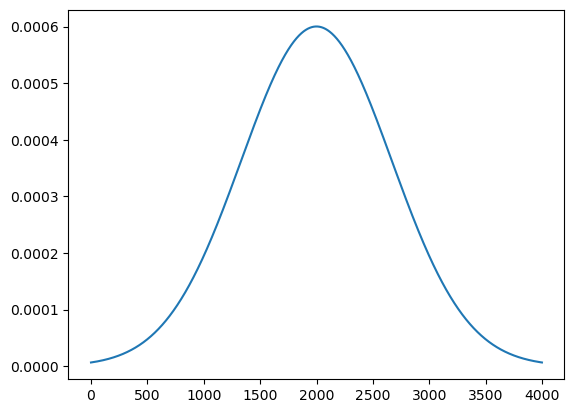

In [30]:
sigma = 0.05
depth = 3
grid_params = Grid(Om=np.linspace(Planck18.Om0 - depth*sigma, Planck18.Om0 + depth*sigma, 4000))
plt.plot(Gaussian(grid_params.Om, Planck18.Om0, sigma))
plt.show()

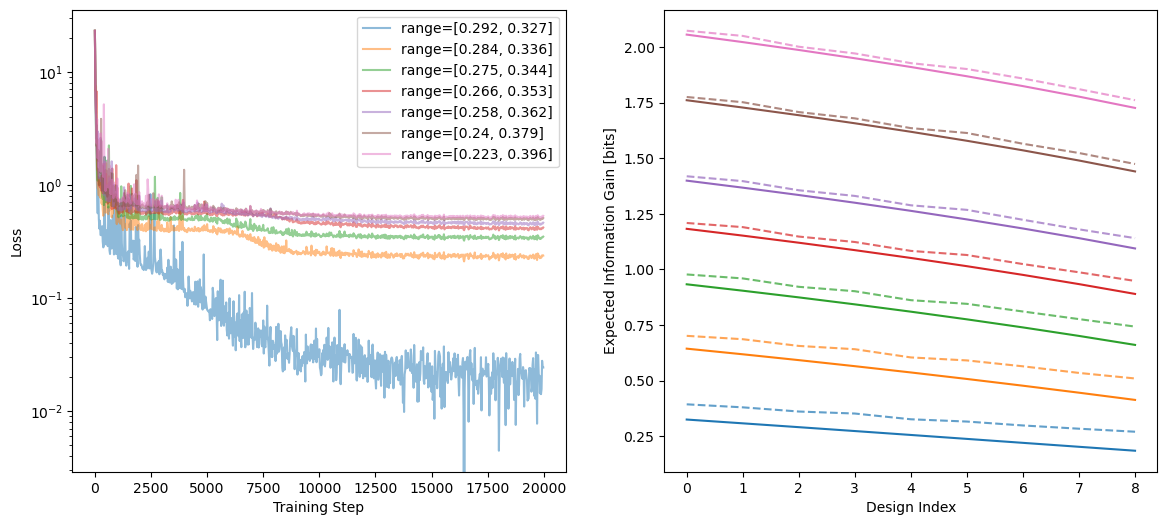

In [5]:
client = MlflowClient()
exp_name = "2_tracers_flat"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
var_name = 'Om_scope'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var_name]))[:-1]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
full_loss = []
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    var = np.round(float(client.get_run(run_id).data.params[var_name]),3)
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs, alpha=0.7, label=f"{var_name}={var}", linestyle='--', color=colors[i])
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs, color=colors[i])
loss = np.array(full_loss)
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    var = float(client.get_run(run_id).data.params[var_name])
    low = np.round(Planck18.Om0 - var, 3)
    high = np.round(Planck18.Om0 + var, 3)
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors[i], label=f"range=[{low}, {high}]")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design Index")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

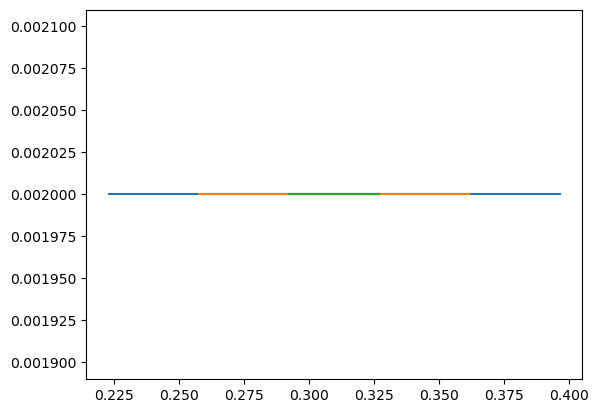

In [ ]:
from bed.grid import Grid, TopHat, CosineBump, Gaussian
from bed.design import ExperimentDesigner
for i in (np.array([0.01, 0.03, 0.05])*np.sqrt(12)/2)[::-1]:

    low = Planck18.Om0 - i
    high = Planck18.Om0 + i
    Om_range = torch.tensor([low, high], device=device)
    grid_params = Grid(Om=np.linspace(*Om_range.cpu().numpy(), 500))
    grid_prior = TopHat(grid_params.Om)
    plt.plot(grid_params.Om, grid_prior)
    grid_prior = Gaussian(grid_params.Om, Planck18.Om0, kwargs["Om_sigma"])
plt.show()

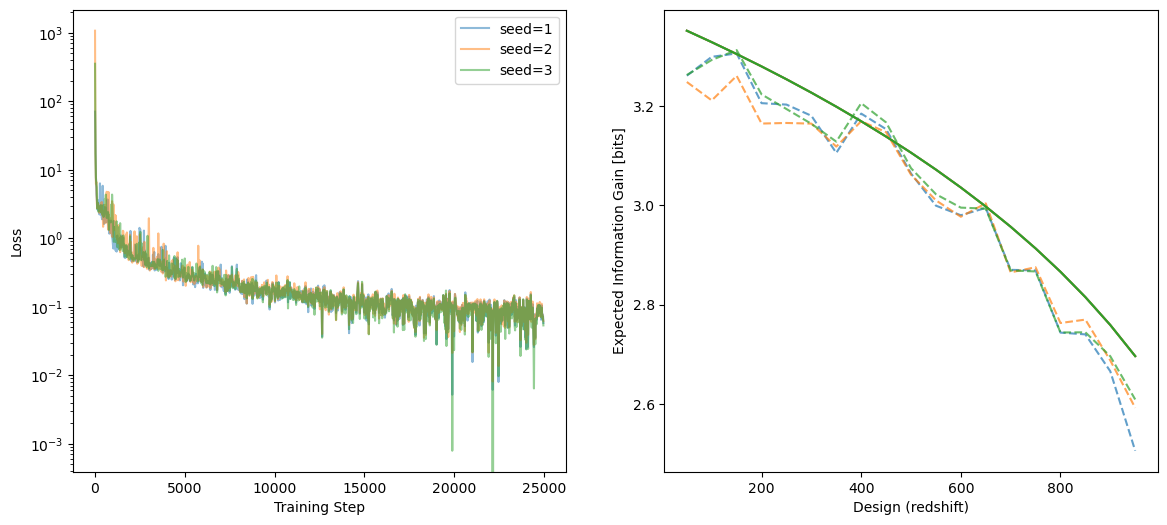

In [10]:

client = MlflowClient()
exp_name = "n_tracers_2D_seed"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'seed'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

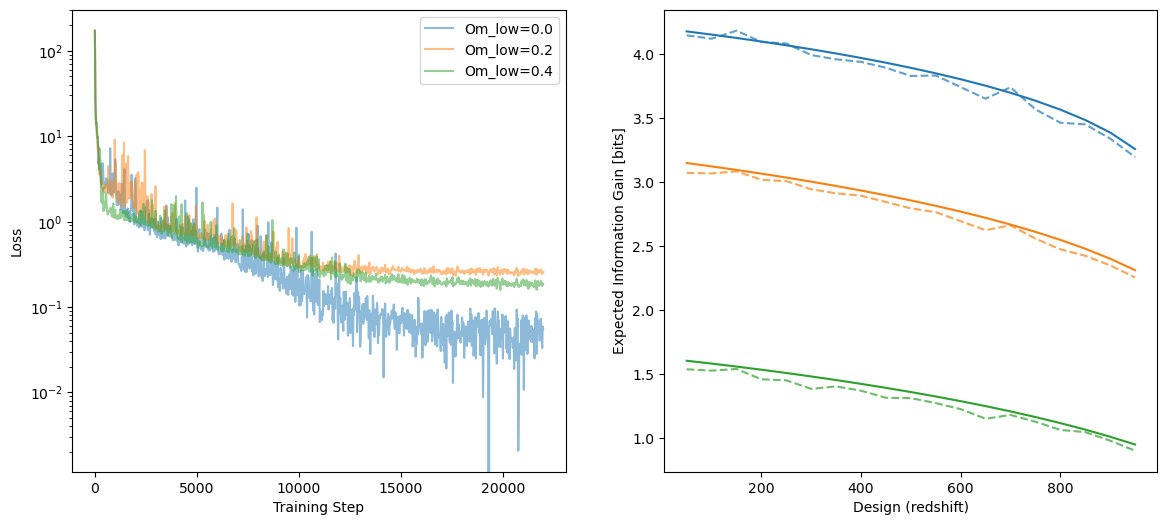

In [15]:

client = MlflowClient()
exp_name = 'n_tracers_Om_flat_low'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_low'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

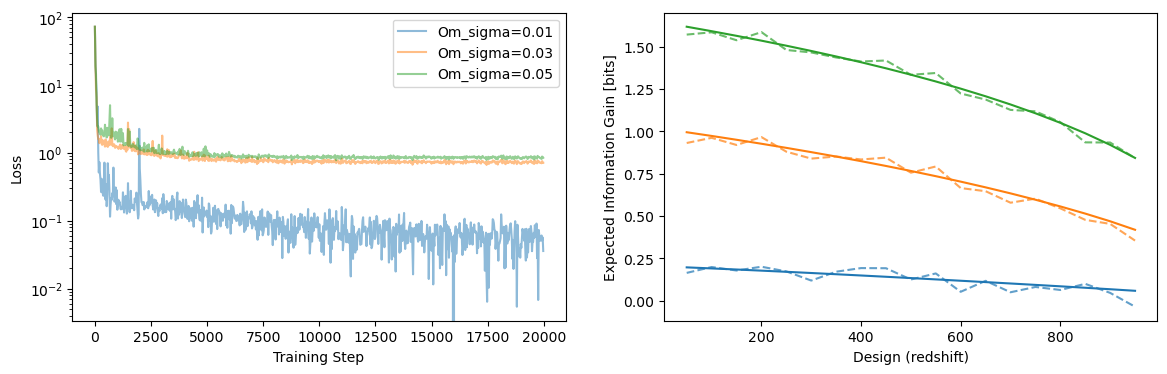

In [8]:

client = MlflowClient()
exp_name = 'n_tracers_2D_w0wa_2.0_sigma'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_sigma'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
final_loss_05 = np.mean(loss[:,-50:], axis=1)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

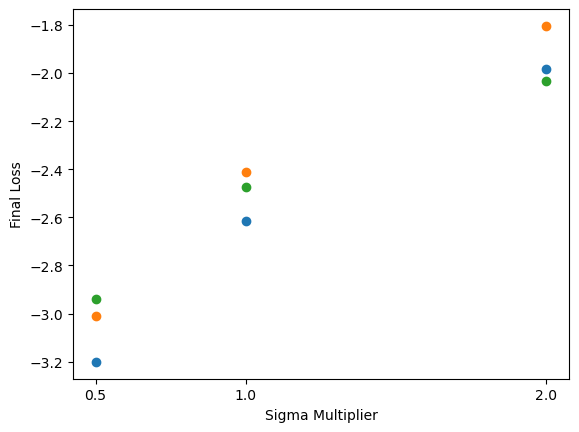

In [51]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(3):
    plt.scatter(0.5, final_loss_05[i], color=colors[i])
    plt.scatter(1.0, final_loss_10[i], color=colors[i])
    plt.scatter(2.0, final_loss_20[i], color=colors[i])
plt.xlabel("Sigma Multiplier")
plt.ylabel("Final Loss")
# show only ticks at 0.5, 1.0, 2.0
plt.xticks([0.5, 1.0, 2.0])
plt.show()

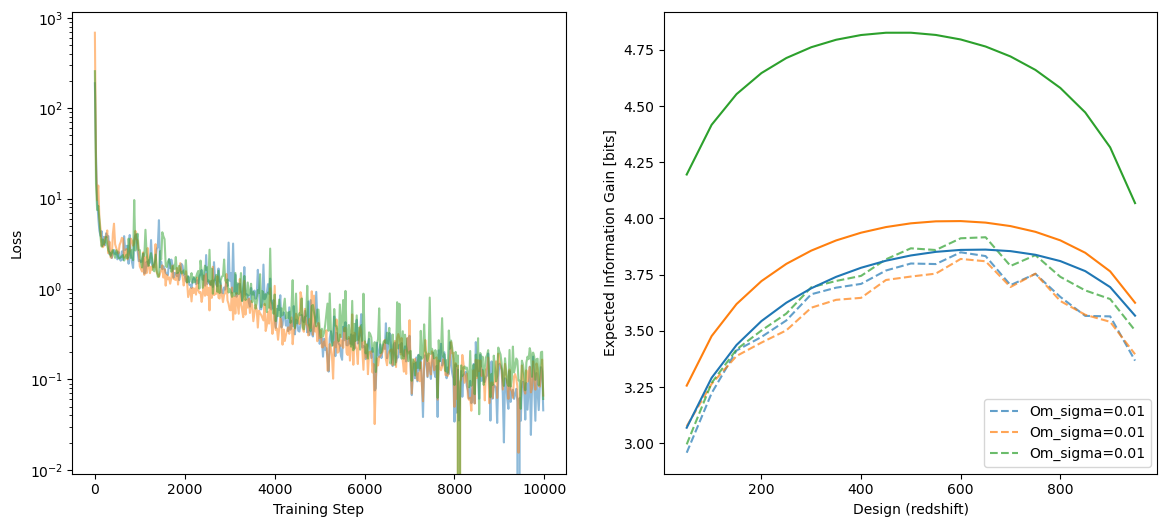

In [25]:
client = MlflowClient()
exp_name = 'n_tracers_w0wa_gaussian_seed'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_sigma'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_gaussian_0.05.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:green')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_gaussian_0.01.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:orange')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_gaussian_0.005.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:blue')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

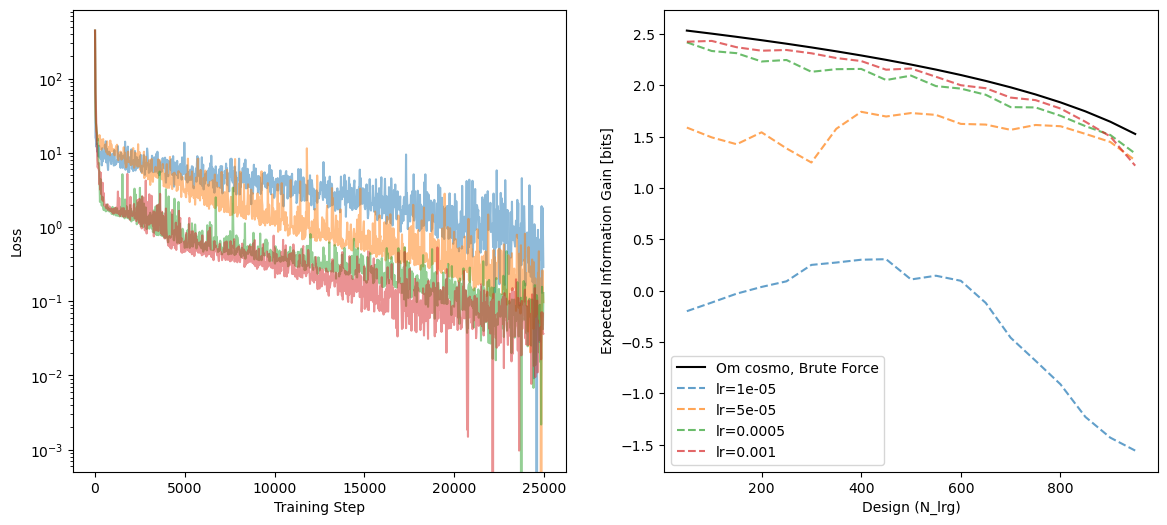

In [34]:
client = MlflowClient()
exp_name = 'n_tracers_lr'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[0:3] + sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[-1:]
ax2.plot(om_grid_eigs[:, 0], om_grid_eigs[:, 1], label="Om cosmo, Brute Force", color='black')
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    lr = client.get_run(run_id).data.params['lr']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"lr={lr}", linestyle='--')
om_grid_eigs = np.load("n_tracers_Om_eigs.npy")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (N_lrg)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

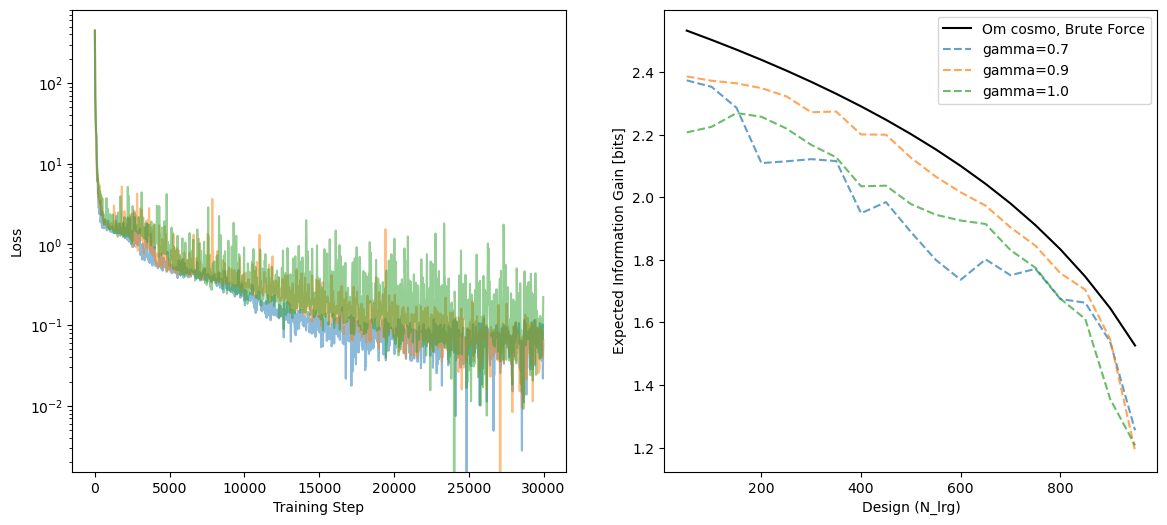

In [4]:
client = MlflowClient()
exp_name = 'n_tracers_gamma'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['gamma']))
om_grid_eigs = np.load("n_tracers_Om_eigs.npy")
ax2.plot(om_grid_eigs[:, 0], om_grid_eigs[:, 1], label="Om cosmo, Brute Force", color='black')
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    gamma = client.get_run(run_id).data.params['gamma']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"gamma={gamma}", linestyle='--')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (N_lrg)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

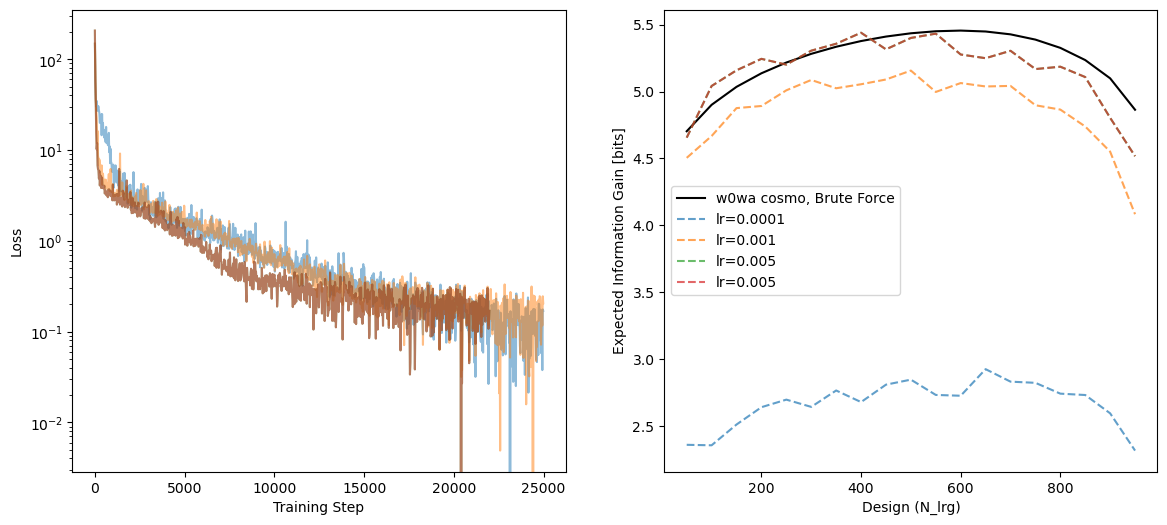

In [6]:
client = MlflowClient()
exp_name = 'n_tracers_w0wa_lr'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[0:3] + sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[-1:]
grid_eigs = np.load("n_tracers_w0wa_eigs_prior.npy")
ax2.plot(grid_eigs[:, 0], grid_eigs[:, 1], label="w0wa cosmo, Brute Force", color='black')
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    lr = client.get_run(run_id).data.params['lr']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"lr={lr}", linestyle='--')


ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (N_lrg)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()